In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import display

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns

import sympy as sym
from sympy import Symbol, sympify, lambdify, abc, SympifyError

from gplearn.genetic import SymbolicClassifier
from sympy import *

import types

import graphviz

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

sns.set_style("darkgrid")

In [2]:
np.random.seed(42)

## Utility Functions

In [3]:
def calculate_function_values_from_sympy(function, data_points, variable_names=None):
    function_vars = None
    
    if variable_names is None:
        variable_names = ['X' + str(i) for i in range(data_points.shape[1])]
    
    if function is None:
        return np.array([np.nan for i in range(data_points.shape[0])])
    try:
        if variable_names is None:
            function_vars = function.atoms(Symbol)
            print(function_vars)
        else:
            function_vars = [sym.symbols(variable_name, real=True) for variable_name in variable_names]
        #print('function_vars', function_vars)
        lambda_function = lambdify([function_vars], function, modules=["scipy", "numpy"])
        #print('lambda_function', lambda_function)
        #print('data_points[0]', data_points[0])
        if len(function_vars) >= 1:
            function_values = [lambda_function(data_point) for data_point in data_points]
            
        else:
            function_values = [lambda_function() for i in range(data_points.shape[0])]
    except (NameError, KeyError) as e:
        #print(e)
        function_values = []
        for data_point in data_points:
            function_value = function.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
            try:
                function_value = float(function_value)
            except TypeError as te:
                #print('te', te)
                #print('function_value', function_value)
                #print('function', function)
                #print('function_vars', function_vars, type(function_vars))
                function_value = np.inf
            function_values.append(function_value)
    function_values = np.nan_to_num(function_values).ravel()
                
    return function_values

In [4]:
def print_decision_tree_nodes(decision_tree): 
    
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has {n} nodes and has "
          "the following tree structure:\n".format(n=n_nodes))
    for i in range(n_nodes):
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i))
        else:
            print("{space}node={node} is a split node: "
                  "go to node {left} if X[:, {feature}] <= {threshold} "
                  "else to node {right}.".format(
                      space=node_depth[i] * "\t",
                      node=i,
                      left=children_left[i],
                      feature=feature[i],
                      threshold=threshold[i],
                      right=children_right[i]))    

## Load Histograms and Data Statistics

In [5]:
with open("./data/summarizing_statistics.pkl", 'rb') as f:
    summarizing_statistics = joblib.load(f)

In [6]:
summarizing_statistics

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000,-3.043901,-1.0,9.212087,110.625000,6.308744,2403.0,"[[4.054988675775044, 1.6181932043448362, 1.438..."
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875,-4.430309,-1.0,7.588837,109.140903,4.138240,2403.0,"[[1.5394827351582467, 0.21880415026212985, 0.7..."
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875,-4.430309,-1.0,9.212087,110.625000,6.308744,2403.0,"[[8.466562429846425, 10.45687699516861, 3.7031..."


In [7]:
with open("./data/hist_on.pkl", 'rb') as f:
    hist_on = joblib.load(f)

In [8]:
with open("./data/hist_off.pkl", 'rb') as f:
    hist_off = joblib.load(f)

In [9]:
print('Total ON:',sum(hist_on.reshape(1,-1)[0]))

Total ON: 9639507


In [10]:
print('Total OFF:',sum(hist_off.reshape(1,-1)[0]))


Total OFF: 16741535


In [11]:
path = "./data/replica_summarizing_statistics.csv"
summarizing_statistics_replica = pd.read_csv(path, index_col=0)

In [12]:
summarizing_statistics_replica

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000000,-3.043901,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[4.05498868e+00 1.61819320e+00 1.43801350e+00...
on_replica,9639507,2.262454,11.145556,0.925975,118.743587,-5.843427,-23.977141,-3.021036,0.000006,10.007755,117.621411,6.767623,2402.992395,[[ 4.60037788e+00 1.66251134e+00 1.59768757e...
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875000,-4.430309,-1.000000,7.588837,109.140903,4.138240,2403.000000,[[ 1.53948274e+00 2.18804150e-01 7.78027734e...
off_replica,16741535,-2.791476,4.517446,-1.396657,107.331233,-9.894227,-37.217121,-4.272182,0.000004,8.534652,106.621120,4.482172,2402.991829,[[ 1.77712398e+00 9.46578975e-02 8.42137846e...
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875000,-4.430309,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[8.46656243e+00 1.04568770e+01 3.70312553e+00...
all_replica,26381042,-0.944794,6.939326,-0.547978,111.501253,-9.894227,-37.217121,-4.272182,0.000004,10.007755,117.621411,6.767623,2402.992395,[[8.73149553e+00 8.43511366e+00 3.84013568e+00...


In [13]:
path = "./data/replica_pump_data.csv"
pump_data_replica = pd.read_csv(path)
print(pump_data_replica.shape)

(26381042, 5)


In [14]:
with open("./data/randForestBest_20201002.pkl", 'rb') as f:
    random_forest_model = joblib.load(f)  

/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Insight into Dataframe

In [15]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [16]:
pump_data_replica.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
count,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07
mean,-9.447940e-01,6.939326e+00,-5.479782e-01,1.115013e+02,3.653952e-01
std,2.954910e+00,9.601276e+00,1.405716e+00,1.955450e+02,4.815408e-01
min,-9.894227e+00,-3.721712e+01,-4.272182e+00,4.127640e-06,0.000000e+00
25%,-3.370405e+00,1.604177e+00,-1.820977e+00,3.802474e+01,0.000000e+00
50%,-2.187935e+00,4.925814e+00,-9.364350e-01,7.603595e+01,0.000000e+00
75%,1.350188e+00,8.836291e+00,5.890964e-01,1.140709e+02,1.000000e+00
max,1.000776e+01,1.176214e+02,6.767623e+00,2.402992e+03,1.000000e+00


In [17]:
pump_data_replica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26381042 entries, 0 to 26381041
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   energy_norm_log    float64
 1   temperature_diff   float64
 2   rms_norm_log       float64
 3   details_ratedhead  float64
 4   state              int64  
dtypes: float64(4), int64(1)
memory usage: 1006.4 MB


In [18]:
legend_fontsize = 25
label_fontsize = 35
plot_fontsize = 30

figsize = (15, 9)
legend_loc = 2

color_1 = '#84b7e9'#'#c0d6ff'
color_2 = '#0a6fd3'#'#96bcff'
color_3 = '#06427e'#'#6ca1ff'


Text(0, 0.5, 'Frequency')

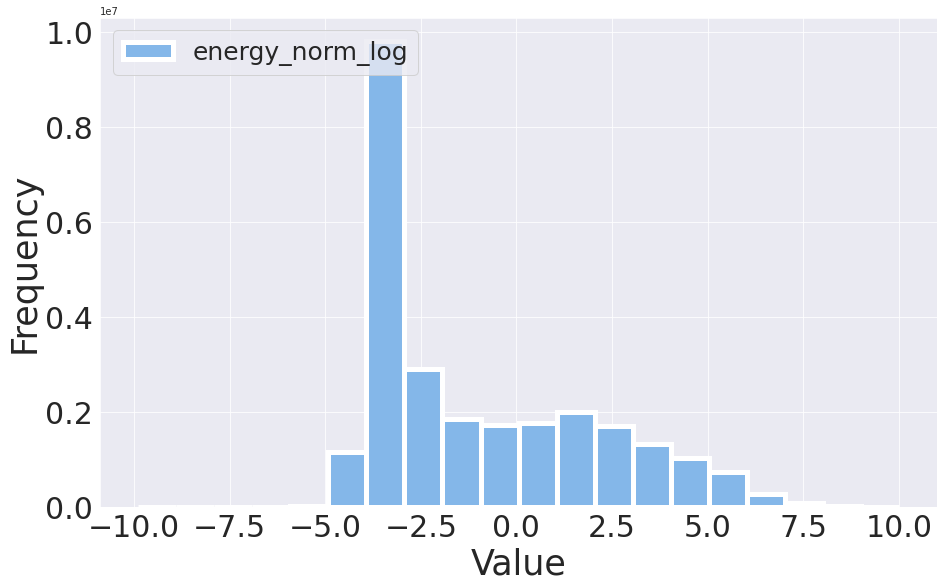

In [19]:
axes = pump_data_replica['energy_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

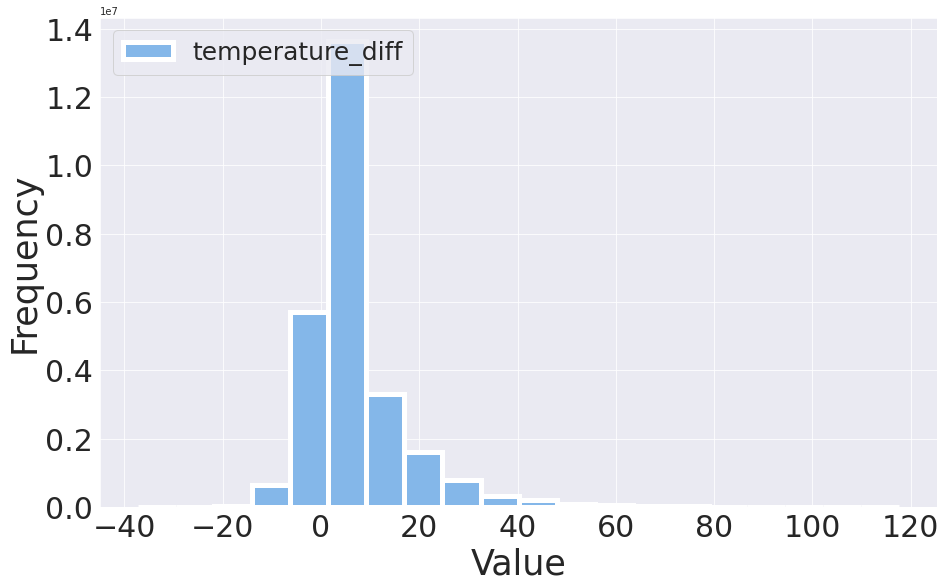

In [20]:
axes = pump_data_replica['temperature_diff'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

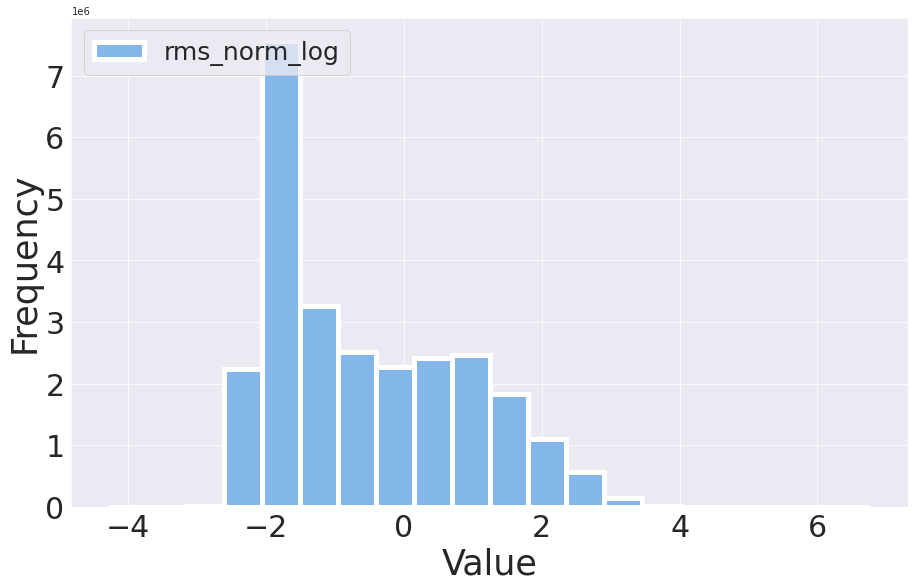

In [21]:
axes = pump_data_replica['rms_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

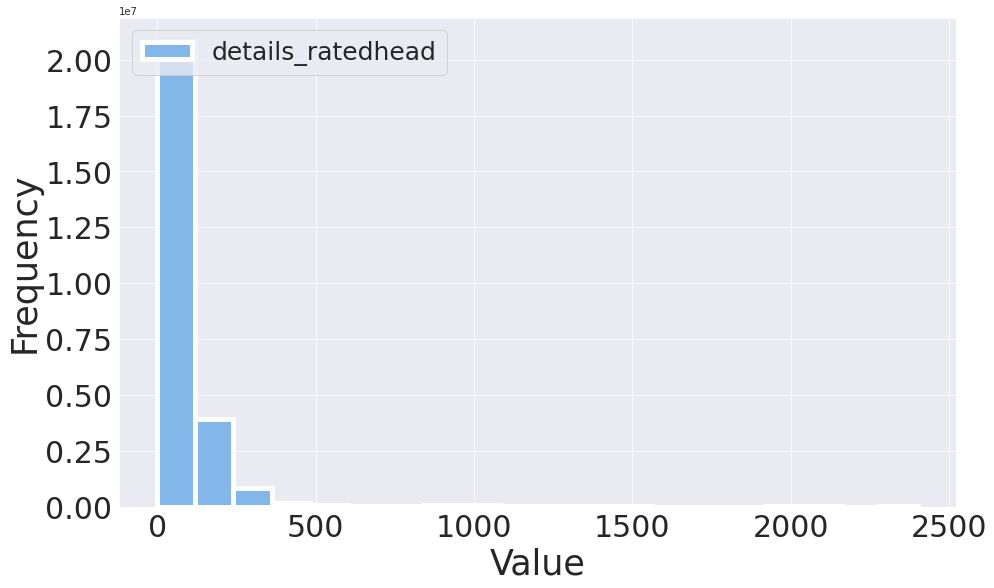

In [22]:
axes = pump_data_replica['details_ratedhead'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

## Generate Data For Symbolic Metamodeling

In [23]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [24]:
data = pump_data_replica.sample(n=10000)

X_data = data.drop(['state'], axis=1) #frac=0.1
y_data = data[['state']] #frac=0.1


In [25]:
X_data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
13880350,-3.435427,2.008345,-1.831309,44.514913
13018525,-3.043470,4.328306,-2.011905,57.427111
22758968,0.059526,3.589398,0.421158,32.645146
26049008,-3.589604,2.368120,-2.103114,466.114163
4688620,0.485113,9.553305,1.172251,54.346425


In [26]:
y_data.head()

,state
13880350,0
13018525,0
22758968,0
26049008,0
4688620,1


In [27]:
X_data.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.903752,6.957620,-0.529029,108.840560
std,2.940251,9.583776,1.391853,179.754406
min,-5.676228,-22.095298,-2.981257,0.004160
25%,-3.347392,1.625078,-1.804050,38.281687
50%,-2.114641,4.917930,-0.892979,77.509069
75%,1.360277,8.790616,0.605675,114.241249
max,8.326624,108.964905,3.778478,2379.037789


In [28]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 13880350 to 9629643
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   energy_norm_log    10000 non-null  float64
 1   temperature_diff   10000 non-null  float64
 2   rms_norm_log       10000 non-null  float64
 3   details_ratedhead  10000 non-null  float64
dtypes: float64(4)
memory usage: 390.6 KB


# Symbolic Metamodeling

In [29]:
metamodeling_hyperparams = {
    'num_iter': 50,#500,
    'batch_size': 128,
    'learning_rate': 0.01,        
    'dataset_size': 50000,
    'exact_expression': True,
    'flat_function': False,
    'polynomial_degree': 3,
    'early_stopping': 20,
    'restarts': 3,
}

symbolic_classification_hyperparams = {     
    'dataset_size': 5000,
}

return_error = True

symbolic_metamodeling = False
symbolic_metamodeling_adjusted = True
symbolic_classification = True

In [30]:
accuracy_score(np.round(np.clip(data['energy_norm_log'].values * 1.631, 0, 1)).astype(int), data['state'].values)

0.9024

In [31]:
data = pump_data_replica.sample(n=metamodeling_hyperparams['dataset_size'])

data_scaled = np.empty_like(data.values.T[:-1])
scaler_list = []

for index, feature in enumerate(data.values.T[:-1]):
    
    scaler = MinMaxScaler(feature_range=(1e-4, 1))
    scaler.fit(feature.reshape(-1, 1))
    scaler_list.append(scaler)
    
    feature_scaled = scaler.transform(feature.reshape(-1, 1)).ravel()
    
    data_scaled[index] = feature_scaled
    
data_scaled = pd.DataFrame(data= data_scaled.T, index=data.index, columns=list(data.columns)[:-1])

In [32]:
data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
3228774,0.722642,5.048562,0.478871,102.441835,1
6648753,2.069493,24.442959,1.769626,66.284119,1
25558960,-1.145248,4.071129,-0.063827,184.503801,0
17578382,-3.199043,4.780609,-1.628835,27.827720,0
4363318,1.854438,2.216334,0.973370,60.624418,1


In [33]:
data_scaled.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
3228774,0.455865,0.214644,0.477619,0.042774
6648753,0.538867,0.377020,0.651340,0.027712
25558960,0.340754,0.206460,0.404578,0.076959
17578382,0.214185,0.212400,0.193946,0.011692
4363318,0.525614,0.190931,0.544173,0.025354


In [34]:
X_data = data.drop(['state'], axis=1).values #frac=0.1
y_data = data[['state']].values #frac=0.1

X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)           
X_train, X_valid, y_train, y_valid= train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=42)   


In [35]:
X_data_scaled = data_scaled.values 
X_train_with_valid_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)           
X_train_scaled, X_valid_scaled = train_test_split(X_train_with_valid_scaled, test_size=0.25, random_state=42)   

In [36]:
print(X_data.shape)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print()

print(y_data.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(50000, 4)
(28125, 4)
(9375, 4)
(12500, 4)

(50000, 1)
(28125, 1)
(9375, 1)
(12500, 1)


## Evaluate Model

In [37]:
y_test_random_forest = random_forest_model.predict(X_test)

accuracy_random_forest = accuracy_score(y_test, y_test_random_forest)

print('Accuracy: '+ str(accuracy_random_forest))


Accuracy: 0.90664


In [38]:
if symbolic_metamodeling:
    from pysymbolic_original.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_original.algorithms.symbolic_expressions import get_symbolic_model
    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_data.shape[0]

    metamodel = symbolic_metamodel(random_forest_model, 
                                   X_train, 
                                   mode="classification")

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])   


    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)


    y_test_metamodel = np.round(metamodel.evaluate(X_test)).astype(np.int64)
    y_test_model = random_forest_model.predict(X_test)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_model_performance)

        


In [39]:
%load_ext autoreload 

In [40]:
if False:
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from xgboost import XGBClassifier
    from sklearn.linear_model import LogisticRegression

    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split


    data          = pd.read_csv("data/absenteeism.csv", delimiter=';')

    feature_names = ['Transportation expense', 'Distance from Residence to Work',
                     'Service time', 'Age', 'Work load Average/day ', 'Hit target',
                     'Disciplinary failure', 'Education', 'Son', 'Social drinker',
                     'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index']

    scaler        = MinMaxScaler(feature_range=(0, 1))
    X             = scaler.fit_transform(data[feature_names])
    Y             = ((data['Absenteeism time in hours'] > 4) * 1) 

    X_train_abse, X_test_abse, Y_train_abse, Y_test_abse = train_test_split(X, Y, test_size=0.33, random_state=42)

    model         = XGBClassifier()

    model.fit(X_train_abse, Y_train_abse)

In [41]:
random_forest_model_scaled = deepcopy(random_forest_model)

for dt in random_forest_model_scaled.estimators_:

    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    for i in range(n_nodes):
        if not is_leaves[i]:  
            threshold[i] = scaler_list[int(feature[i])].transform(np.array([threshold[i]]).reshape(1, -1)).ravel()[0]

In [42]:
#%autoreload 2
if symbolic_metamodeling_adjusted:
    from pysymbolic_adjusted.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_adjusted.algorithms.symbolic_expressions import get_symbolic_model    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_train_scaled.shape[0]

    metamodel = symbolic_metamodel(random_forest_model_scaled, #random_forest_model, #model,#
                                   X_train_scaled, #X_train, #X_train_abse,#
                                   mode="classification", 
                                   approximation_order = metamodeling_hyperparams['polynomial_degree'], 
                                   force_polynomial=metamodeling_hyperparams['flat_function'],
                                   verbosity=True,
                                   early_stopping=metamodeling_hyperparams['early_stopping'],
                                   restarts=metamodeling_hyperparams['restarts'])

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])    

    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)

    y_test_metamodel_eval = np.round(metamodel.evaluate(X_test_scaled)).astype(np.int64)
    
    y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test_scaled), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)

    
    y_test_model = random_forest_model_scaled.predict(X_test_scaled)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 
    accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 
    f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
    
    f1_fidelity = f1_score(y_test_model, y_test_metamodel)     
    f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
    print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
    print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
    
    print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
    print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

---- Tuning the basis functions ----


basis function loop:   0%|          | 0/4 [00:00<?, ?it/s]


restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.842
Iteration: 1 	--- Loss: 35.041
Iteration: 2 	--- Loss: 38.002
Iteration: 3 	--- Loss: 36.659
Iteration: 4 	--- Loss: 36.023
Iteration: 5 	--- Loss: 36.162
Iteration: 6 	--- Loss: 34.193
Iteration: 7 	--- Loss: 34.989
Iteration: 8 	--- Loss: 36.160
Iteration: 9 	--- Loss: 33.841
Iteration: 10 	--- Loss: 35.420
Iteration: 11 	--- Loss: 34.392
Iteration: 12 	--- Loss: 35.069
Iteration: 13 	--- Loss: 34.263
Iteration: 14 	--- Loss: 35.108
Iteration: 15 	--- Loss: 35.732
Iteration: 16 	--- Loss: 31.520
Iteration: 17 	--- Loss: 33.090
Iteration: 18 	--- Loss: 31.472
Iteration: 19 	--- Loss: 33.349
Iteration: 20 	--- Loss: 29.448
Iteration: 21 	--- Loss: 31.078
Iteration: 22 	--- Loss: 36.169
Iteration: 23 	--- Loss: 37.518
Iteration: 24 	--- Loss: 36.470
Iteration: 25 	--- Loss: 41.831
Iteration: 26 	--- Loss: 43.902
Iteration: 27 	--- Loss: 44.953
Iteration: 28 	--- Loss: 46.863
Iteration: 29 	--- Loss: 50.071
Iteration: 30 	--- Loss: 48.256
Iteration: 31 	---


restart loop:  25%|██▌       | 1/4 [02:39<07:58, 159.63s/it]

Iteration: 41 	--- Loss: 35.653
Early Stopping requirement reached after 41 Iterations
New Global Minimum: 29.44776203284286


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.538
Iteration: 1 	--- Loss: 35.071
Iteration: 2 	--- Loss: 34.917
Iteration: 3 	--- Loss: 34.899
Iteration: 4 	--- Loss: 37.479
Iteration: 5 	--- Loss: 35.529
Iteration: 6 	--- Loss: 38.240
Iteration: 7 	--- Loss: 35.679
Iteration: 8 	--- Loss: 33.867
Iteration: 9 	--- Loss: 34.198
Iteration: 10 	--- Loss: 38.169
Iteration: 11 	--- Loss: 38.094
Iteration: 12 	--- Loss: 35.596
Iteration: 13 	--- Loss: 35.947
Iteration: 14 	--- Loss: 35.090
Iteration: 15 	--- Loss: 34.164
Iteration: 16 	--- Loss: 35.647
Iteration: 17 	--- Loss: 32.567
Iteration: 18 	--- Loss: 34.592
Iteration: 19 	--- Loss: 31.475
Iteration: 20 	--- Loss: 34.189
Iteration: 21 	--- Loss: 35.060
Iteration: 22 	--- Loss: 31.843
Iteration: 23 	--- Loss: 32.166
Iteration: 24 	--- Loss: 34.297
Iteration: 25 	--- Loss: 35.584
Iteration: 26 	--- Loss: 33.215
Iteration: 27 	--- Loss: 32.794
Iteration: 28 	--- Loss: 33.696
Iteration: 29 	--- Loss: 32.219
Iteration: 30 	--- Loss: 34.081
Iteration: 31 	---


restart loop:  50%|█████     | 2/4 [05:08<05:06, 153.11s/it]

Iteration: 40 	--- Loss: 35.836
Early Stopping requirement reached after 40 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.229
Iteration: 1 	--- Loss: 36.913
Iteration: 2 	--- Loss: 35.451
Iteration: 3 	--- Loss: 35.759
Iteration: 4 	--- Loss: 34.920
Iteration: 5 	--- Loss: 38.425
Iteration: 6 	--- Loss: 37.348
Iteration: 7 	--- Loss: 36.296
Iteration: 8 	--- Loss: 35.859
Iteration: 9 	--- Loss: 34.983
Iteration: 10 	--- Loss: 39.494
Iteration: 11 	--- Loss: 37.325
Iteration: 12 	--- Loss: 36.995
Iteration: 13 	--- Loss: 37.620
Iteration: 14 	--- Loss: 38.587
Iteration: 15 	--- Loss: 36.779
Iteration: 16 	--- Loss: 39.562
Iteration: 17 	--- Loss: 35.577
Iteration: 18 	--- Loss: 37.522
Iteration: 19 	--- Loss: 37.277
Iteration: 20 	--- Loss: 34.820
Iteration: 21 	--- Loss: 37.928
Iteration: 22 	--- Loss: 34.991
Iteration: 23 	--- Loss: 36.301
Iteration: 24 	--- Loss: 33.781
Iteration: 25 	--- Loss: 34.433
Iteration: 26 	--- Loss: 34.988
Iteration: 27 	--- Loss: 33.570
Iteration: 28 	--- Loss: 36.930
Iteration: 29 	--- Loss: 33.502
Iteration: 30 	--- Loss: 32.625
Iteration: 31 	---


restart loop:  75%|███████▌  | 3/4 [08:29<02:55, 175.17s/it]

Iteration: 55 	--- Loss: 38.803
Early Stopping requirement reached after 55 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.462
Iteration: 1 	--- Loss: 37.984
Iteration: 2 	--- Loss: 39.025
Iteration: 3 	--- Loss: 38.243
Iteration: 4 	--- Loss: 36.834
Iteration: 5 	--- Loss: 35.888
Iteration: 6 	--- Loss: 37.195
Iteration: 7 	--- Loss: 36.487
Iteration: 8 	--- Loss: 34.532
Iteration: 9 	--- Loss: 34.807
Iteration: 10 	--- Loss: 34.818
Iteration: 11 	--- Loss: 38.254
Iteration: 12 	--- Loss: 38.310
Iteration: 13 	--- Loss: 38.672
Iteration: 14 	--- Loss: 35.698
Iteration: 15 	--- Loss: 36.918
Iteration: 16 	--- Loss: 38.326
Iteration: 17 	--- Loss: 37.010
Iteration: 18 	--- Loss: 38.477
Iteration: 19 	--- Loss: 39.426
Iteration: 20 	--- Loss: 37.558
Iteration: 21 	--- Loss: 39.604
Iteration: 22 	--- Loss: 35.283
Iteration: 23 	--- Loss: 36.932
Iteration: 24 	--- Loss: 36.343
Iteration: 25 	--- Loss: 38.048
Iteration: 26 	--- Loss: 35.731
Iteration: 27 	--- Loss: 37.545
Iteration: 28 	--- Loss: 39.438



restart loop: 100%|██████████| 4/4 [09:57<00:00, 149.42s/it]

restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration: 29 	--- Loss: 37.091
Early Stopping requirement reached after 29 Iterations
return abc 4.0665617 2.0059013 3.0105076


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.466
Iteration: 1 	--- Loss: 37.841
Iteration: 2 	--- Loss: 35.164
Iteration: 3 	--- Loss: 39.040
Iteration: 4 	--- Loss: 36.692
Iteration: 5 	--- Loss: 36.249
Iteration: 6 	--- Loss: 37.573
Iteration: 7 	--- Loss: 35.734
Iteration: 8 	--- Loss: 37.974
Iteration: 9 	--- Loss: 37.243
Iteration: 10 	--- Loss: 35.422
Iteration: 11 	--- Loss: 36.143
Iteration: 12 	--- Loss: 37.189
Iteration: 13 	--- Loss: 37.784
Iteration: 14 	--- Loss: 36.024
Iteration: 15 	--- Loss: 36.848
Iteration: 16 	--- Loss: 33.428
Iteration: 17 	--- Loss: 35.507
Iteration: 18 	--- Loss: 39.485
Iteration: 19 	--- Loss: 37.568
Iteration: 20 	--- Loss: 35.598
Wrong c Value: -0.0007666284
te can't convert complex to float
function_value -2.60946865793742e-12 + 1.42944499903379e-13*I
function 8.68991793379371e-11*x**2.98258*exp(2.98258*I*pi)*hyper((1.0, 1.0), (3.98321,), 0.000766628421843052*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 


restart loop:  25%|██▌       | 1/4 [01:03<03:09, 63.00s/it]

te can't convert complex to float
function_value -1.23955448090251e-12 + 6.79017526562876e-14*I
function 8.68991793379371e-11*x**2.98258*exp(2.98258*I*pi)*hyper((1.0, 1.0), (3.98321,), 0.000766628421843052*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.92372760886224e-13 + 1.60159341110024e-14*I
function 8.68991793379371e-11*x**2.98258*exp(2.98258*I*pi)*hyper((1.0, 1.0), (3.98321,), 0.000766628421843052*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.07366031656748e-12 + 5.88142097629757e-14*I
function 8.68991793379371e-11*x**2.98258*exp(2.98258*I*pi)*hyper((1.0, 1.0), (3.98321,), 0.000766628421843052*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.8544540154482e-12 + 1.56364591885135e-13*I
function 8.68991793379371e-11*x**2.98258*exp(2.98258*I*pi)*hyper((1.0, 1.0), (3.98321,), 0.000766628421843052*x*exp_polar(2*I

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.850
Iteration: 1 	--- Loss: 36.220
Iteration: 2 	--- Loss: 37.203
Iteration: 3 	--- Loss: 36.577
Iteration: 4 	--- Loss: 38.532
Iteration: 5 	--- Loss: 36.046
Iteration: 6 	--- Loss: 36.233
Iteration: 7 	--- Loss: 35.378
Iteration: 8 	--- Loss: 36.756
Iteration: 9 	--- Loss: 37.020
Iteration: 10 	--- Loss: 36.433
Iteration: 11 	--- Loss: 35.308
Iteration: 12 	--- Loss: 37.200
Iteration: 13 	--- Loss: 38.571
Iteration: 14 	--- Loss: 38.581
Iteration: 15 	--- Loss: 37.668
Iteration: 16 	--- Loss: 37.155
Iteration: 17 	--- Loss: 36.647
Iteration: 18 	--- Loss: 35.027
Iteration: 19 	--- Loss: 35.730
Iteration: 20 	--- Loss: 35.820
Iteration: 21 	--- Loss: 34.362
Iteration: 22 	--- Loss: 34.524
Iteration: 23 	--- Loss: 35.141
Iteration: 24 	--- Loss: 35.560
Iteration: 25 	--- Loss: 33.753
Iteration: 26 	--- Loss: 35.052
Iteration: 27 	--- Loss: 30.852
Iteration: 28 	--- Loss: 31.467
Iteration: 29 	--- Loss: 28.161
Iteration: 30 	--- Loss: 32.876
Iteration: 31 	---


restart loop:  50%|█████     | 2/4 [05:01<05:33, 166.52s/it]

Iteration: 80 	--- Loss: 27.690
Early Stopping requirement reached after 80 Iterations
New Global Minimum: 26.182175823624394


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.777
Iteration: 1 	--- Loss: 37.251
Iteration: 2 	--- Loss: 37.285
Iteration: 3 	--- Loss: 32.377
Iteration: 4 	--- Loss: 35.617
Iteration: 5 	--- Loss: 37.223
Iteration: 6 	--- Loss: 36.695
Iteration: 7 	--- Loss: 35.869
Iteration: 8 	--- Loss: 35.220
Iteration: 9 	--- Loss: 34.916
Iteration: 10 	--- Loss: 36.588
Iteration: 11 	--- Loss: 37.875
Wrong c Value: -0.06766173
te can't convert complex to float
function_value -4.56722944968909e-7 - 2.61646146317958e-7*I
function 2.48084483091307e-5*x**3.1656*exp(3.1656*I*pi)*hyper((1.0, 1.0), (4.22288,), 0.0676617324352264*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.73900856808947e-8 - 5.57925562721979e-8*I
function 2.48084483091307e-5*x**3.1656*exp(3.1656*I*pi)*hyper((1.0, 1.0), (4.22288,), 0.0676617324352264*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.16699126707211e-6 - 6.68542649717135e-7*I


restart loop:  75%|███████▌  | 3/4 [05:41<01:48, 108.33s/it]

te can't convert complex to float
function_value -9.96991163849899e-8 - 5.71153472379496e-8*I
function 2.48084483091307e-5*x**3.1656*exp(3.1656*I*pi)*hyper((1.0, 1.0), (4.22288,), 0.0676617324352264*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.42286538224779e-8 - 1.96088141945933e-8*I
function 2.48084483091307e-5*x**3.1656*exp(3.1656*I*pi)*hyper((1.0, 1.0), (4.22288,), 0.0676617324352264*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
Iteration: 12 	--- Loss: inf
BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] 4.669708781926224
a_new, b_new, c_new nan nan nan
best_parameters abc 2.3595164 0.8480721 0.7200762


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.292
Iteration: 1 	--- Loss: 40.386
Iteration: 2 	--- Loss: 36.226
Iteration: 3 	--- Loss: 37.431
Iteration: 4 	--- Loss: 34.818
Iteration: 5 	--- Loss: 38.989
Iteration: 6 	--- Loss: 34.833
Iteration: 7 	--- Loss: 38.341
Iteration: 8 	--- Loss: 36.252
Iteration: 9 	--- Loss: 37.377
Wrong c Value: -0.115479484
te can't convert complex to float
function_value -4.78053399141886e-5 + 0.000104964528169172*I
function 0.00379900420696053*x**2.63604*exp(2.63604*I*pi)*hyper((1.0, 1.0), (1.3699,), 0.115479484200478*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.81693869931915e-5 + 6.18505468188836e-5*I
function 0.00379900420696053*x**2.63604*exp(2.63604*I*pi)*hyper((1.0, 1.0), (1.3699,), 0.115479484200478*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.76991161307498e-5 + 0.0002145145635533*I
function 0.00379900420696053*x**2.63604*exp(2.63604*I*pi)*hype


restart loop: 100%|██████████| 4/4 [06:14<00:00, 93.53s/it] 

te can't convert complex to float
function_value -1.83791835188537e-5 + 4.03545363269875e-5*I
function 0.00379900420696053*x**2.63604*exp(2.63604*I*pi)*hyper((1.0, 1.0), (1.3699,), 0.115479484200478*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.38149314360308e-5 + 5.22896196544403e-5*I
function 0.00379900420696053*x**2.63604*exp(2.63604*I*pi)*hyper((1.0, 1.0), (1.3699,), 0.115479484200478*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -7.44193490152507e-5 + 0.000163399985651484*I
function 0.00379900420696053*x**2.63604*exp(2.63604*I*pi)*hyper((1.0, 1.0), (1.3699,), 0.115479484200478*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.84623954272778e-5 + 4.05372418306294e-5*I
function 0.00379900420696053*x**2.63604*exp(2.63604*I*pi)*hyper((1.0, 1.0), (1.3699,), 0.115479484200478*x*exp_polar(2*I*pi))
function_vars [x] <c



restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.960
Iteration: 1 	--- Loss: 37.842
Iteration: 2 	--- Loss: 33.768
Iteration: 3 	--- Loss: 37.183
Iteration: 4 	--- Loss: 37.609
Iteration: 5 	--- Loss: 37.916
Iteration: 6 	--- Loss: 34.523
Iteration: 7 	--- Loss: 39.840
Iteration: 8 	--- Loss: 34.767
Iteration: 9 	--- Loss: 34.604
Iteration: 10 	--- Loss: 33.611
Iteration: 11 	--- Loss: 37.339
Iteration: 12 	--- Loss: 36.837
Iteration: 13 	--- Loss: 34.195
Iteration: 14 	--- Loss: 32.487
Iteration: 15 	--- Loss: 37.961
Iteration: 16 	--- Loss: 31.893
Iteration: 17 	--- Loss: 33.269
Iteration: 18 	--- Loss: 31.229
Iteration: 19 	--- Loss: 33.850
Iteration: 20 	--- Loss: 33.466
Iteration: 21 	--- Loss: 31.700
Iteration: 22 	--- Loss: 33.083
Iteration: 23 	--- Loss: 37.867
Iteration: 24 	--- Loss: 35.174
Iteration: 25 	--- Loss: 38.996
Iteration: 26 	--- Loss: 42.661
Iteration: 27 	--- Loss: 45.065
Iteration: 28 	--- Loss: 50.790
Iteration: 29 	--- Loss: 48.226
Iteration: 30 	--- Loss: 43.211
Iteration: 31 	---


restart loop:  25%|██▌       | 1/4 [02:31<07:35, 151.94s/it]

Iteration: 39 	--- Loss: 37.277
Early Stopping requirement reached after 39 Iterations
New Global Minimum: 31.228927157624874


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.315
Iteration: 1 	--- Loss: 36.154
Iteration: 2 	--- Loss: 40.066
Iteration: 3 	--- Loss: 38.244
Iteration: 4 	--- Loss: 36.328
Iteration: 5 	--- Loss: 37.119
Iteration: 6 	--- Loss: 36.111
Iteration: 7 	--- Loss: 36.627
Iteration: 8 	--- Loss: 35.377
Iteration: 9 	--- Loss: 38.976
Iteration: 10 	--- Loss: 37.263
Iteration: 11 	--- Loss: 35.768
Iteration: 12 	--- Loss: 35.845
Iteration: 13 	--- Loss: 35.093
Iteration: 14 	--- Loss: 36.708
Iteration: 15 	--- Loss: 35.427
Iteration: 16 	--- Loss: 37.228
Iteration: 17 	--- Loss: 36.801
Iteration: 18 	--- Loss: 34.914
Iteration: 19 	--- Loss: 34.395
Iteration: 20 	--- Loss: 37.619
Iteration: 21 	--- Loss: 33.598
Iteration: 22 	--- Loss: 36.727
Iteration: 23 	--- Loss: 34.974
Iteration: 24 	--- Loss: 33.925
Iteration: 25 	--- Loss: 36.110
Iteration: 26 	--- Loss: 34.430
Iteration: 27 	--- Loss: 33.742
Iteration: 28 	--- Loss: 35.106
Iteration: 29 	--- Loss: 32.243
Iteration: 30 	--- Loss: 33.353
Iteration: 31 	---


restart loop:  50%|█████     | 2/4 [06:50<07:09, 214.90s/it]

Iteration: 52 	--- Loss: 36.108
Early Stopping requirement reached after 52 Iterations
New Global Minimum: 30.29963370508284


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.901
Iteration: 1 	--- Loss: 38.205
Iteration: 2 	--- Loss: 38.334
Iteration: 3 	--- Loss: 36.355
Iteration: 4 	--- Loss: 35.250
Iteration: 5 	--- Loss: 36.519
Iteration: 6 	--- Loss: 36.997
Iteration: 7 	--- Loss: 35.852
Iteration: 8 	--- Loss: 35.139
Iteration: 9 	--- Loss: 37.502
Iteration: 10 	--- Loss: 37.586
Iteration: 11 	--- Loss: 35.623
Iteration: 12 	--- Loss: 36.540
Iteration: 13 	--- Loss: 37.959
Iteration: 14 	--- Loss: 37.093
Iteration: 15 	--- Loss: 38.655
Iteration: 16 	--- Loss: 36.016
Iteration: 17 	--- Loss: 36.487
Iteration: 18 	--- Loss: 37.875
Iteration: 19 	--- Loss: 37.120
Iteration: 20 	--- Loss: 36.568
Iteration: 21 	--- Loss: 36.337
Iteration: 22 	--- Loss: 34.439
Iteration: 23 	--- Loss: 37.846
Iteration: 24 	--- Loss: 39.063
Iteration: 25 	--- Loss: 36.559
Iteration: 26 	--- Loss: 37.973
Iteration: 27 	--- Loss: 39.195
Iteration: 28 	--- Loss: 37.648
Iteration: 29 	--- Loss: 37.401
Iteration: 30 	--- Loss: 36.803
Iteration: 31 	---


restart loop:  75%|███████▌  | 3/4 [11:08<03:54, 234.47s/it]

Iteration: 43 	--- Loss: 35.922
Early Stopping requirement reached after 43 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.493
Iteration: 1 	--- Loss: 37.874
Iteration: 2 	--- Loss: 35.183
Iteration: 3 	--- Loss: 36.164
Iteration: 4 	--- Loss: 36.459
Iteration: 5 	--- Loss: 35.410
Iteration: 6 	--- Loss: 36.181
Iteration: 7 	--- Loss: 34.326
Iteration: 8 	--- Loss: 34.342
Iteration: 9 	--- Loss: 33.908
Iteration: 10 	--- Loss: 36.475
Iteration: 11 	--- Loss: 36.184
Iteration: 12 	--- Loss: 36.192
Iteration: 13 	--- Loss: 34.419
Iteration: 14 	--- Loss: 37.059
Iteration: 15 	--- Loss: 35.233
Iteration: 16 	--- Loss: 34.151
Iteration: 17 	--- Loss: 34.144
Iteration: 18 	--- Loss: 33.034
Iteration: 19 	--- Loss: 32.791
Iteration: 20 	--- Loss: 34.694
Iteration: 21 	--- Loss: 35.935
Iteration: 22 	--- Loss: 38.419
Iteration: 23 	--- Loss: 47.113
Iteration: 24 	--- Loss: 56.230
Iteration: 25 	--- Loss: 52.504
Iteration: 26 	--- Loss: 44.773
Iteration: 27 	--- Loss: 40.193
Iteration: 28 	--- Loss: 36.713
Iteration: 29 	--- Loss: 39.599
Iteration: 30 	--- Loss: 41.972
Iteration: 31 	---


restart loop: 100%|██████████| 4/4 [16:21<00:00, 245.35s/it]

restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration: 40 	--- Loss: 40.239
Early Stopping requirement reached after 40 Iterations
return abc 3.8865008 1.719253 3.0341656


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.828
Iteration: 1 	--- Loss: 40.344
Iteration: 2 	--- Loss: 35.779
Iteration: 3 	--- Loss: 37.279
Iteration: 4 	--- Loss: 35.122
Iteration: 5 	--- Loss: 37.237
Iteration: 6 	--- Loss: 38.706
Iteration: 7 	--- Loss: 36.515
Iteration: 8 	--- Loss: 36.448
Iteration: 9 	--- Loss: 39.324
Iteration: 10 	--- Loss: 37.265
Iteration: 11 	--- Loss: 37.039
Iteration: 12 	--- Loss: 38.020
Iteration: 13 	--- Loss: 36.043
Iteration: 14 	--- Loss: 35.474
Iteration: 15 	--- Loss: 38.544
Iteration: 16 	--- Loss: 36.664
Iteration: 17 	--- Loss: 37.314
Iteration: 18 	--- Loss: 37.994
Iteration: 19 	--- Loss: 34.619
Iteration: 20 	--- Loss: 36.537
Iteration: 21 	--- Loss: 37.313
Iteration: 22 	--- Loss: 35.125
Iteration: 23 	--- Loss: 38.301
Iteration: 24 	--- Loss: 36.740
Iteration: 25 	--- Loss: 37.086
Iteration: 26 	--- Loss: 35.830
Iteration: 27 	--- Loss: 37.989
Iteration: 28 	--- Loss: 34.905
Iteration: 29 	--- Loss: 34.880
Iteration: 30 	--- Loss: 37.474
Iteration: 31 	---


restart loop:  25%|██▌       | 1/4 [03:49<11:29, 229.74s/it]

Iteration: 40 	--- Loss: 36.588
Early Stopping requirement reached after 40 Iterations
New Global Minimum: 34.6187586410504


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.879
Iteration: 1 	--- Loss: 36.423
Iteration: 2 	--- Loss: 38.601
Iteration: 3 	--- Loss: 37.996
Iteration: 4 	--- Loss: 34.794
Iteration: 5 	--- Loss: 39.256
Iteration: 6 	--- Loss: 36.943
Iteration: 7 	--- Loss: 37.831
Iteration: 8 	--- Loss: 37.875
Iteration: 9 	--- Loss: 37.134
Iteration: 10 	--- Loss: 38.720
Iteration: 11 	--- Loss: 36.159
Iteration: 12 	--- Loss: 36.777
Iteration: 13 	--- Loss: 38.658
Iteration: 14 	--- Loss: 41.336
Iteration: 15 	--- Loss: 36.095
Iteration: 16 	--- Loss: 37.084
Iteration: 17 	--- Loss: 38.680
Iteration: 18 	--- Loss: 35.725
Iteration: 19 	--- Loss: 36.629
Iteration: 20 	--- Loss: 38.476
Iteration: 21 	--- Loss: 37.833
Iteration: 22 	--- Loss: 38.343
Iteration: 23 	--- Loss: 37.333
Iteration: 24 	--- Loss: 37.209



restart loop:  50%|█████     | 2/4 [06:10<05:55, 177.51s/it]

Iteration: 25 	--- Loss: 36.041
Early Stopping requirement reached after 25 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.519
Iteration: 1 	--- Loss: 36.986
Iteration: 2 	--- Loss: 36.426
Iteration: 3 	--- Loss: 37.406
Iteration: 4 	--- Loss: 38.049
Iteration: 5 	--- Loss: 37.544
Iteration: 6 	--- Loss: 37.548
Iteration: 7 	--- Loss: 36.762
Iteration: 8 	--- Loss: 36.344
Iteration: 9 	--- Loss: 36.296
Iteration: 10 	--- Loss: 36.802
Iteration: 11 	--- Loss: 37.184
Iteration: 12 	--- Loss: 39.304
Iteration: 13 	--- Loss: 35.099
Iteration: 14 	--- Loss: 37.216
Iteration: 15 	--- Loss: 38.929
Iteration: 16 	--- Loss: 35.768
Iteration: 17 	--- Loss: 36.980
Iteration: 18 	--- Loss: 40.466
Iteration: 19 	--- Loss: 35.527
Iteration: 20 	--- Loss: 36.964
Iteration: 21 	--- Loss: 36.570
Iteration: 22 	--- Loss: 35.891
Iteration: 23 	--- Loss: 37.413
Iteration: 24 	--- Loss: 36.953
Iteration: 25 	--- Loss: 38.798
Iteration: 26 	--- Loss: 37.480
Wrong c Value: -0.010343688
te can't convert complex to float
function_value 1.06184450239542e-13 - 2.15547146469901e-13*I
function 1.179351280040


restart loop:  75%|███████▌  | 3/4 [08:51<02:49, 169.87s/it]

 can't convert complex to float
function_value 3.58004588274907e-12 - 7.26724744081705e-12*I
function 1.17935128004096e-8*x**3.6457*exp(3.6457*I*pi)*hyper((1.0, 1.0), (3.83617,), 0.0103436876088381*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.74377966420503e-14 - 7.59961578000366e-14*I
function 1.17935128004096e-8*x**3.6457*exp(3.6457*I*pi)*hyper((1.0, 1.0), (3.83617,), 0.0103436876088381*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.31294693890144e-13 - 2.66519217746261e-13*I
function 1.17935128004096e-8*x**3.6457*exp(3.6457*I*pi)*hyper((1.0, 1.0), (3.83617,), 0.0103436876088381*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.17874784457681e-14 - 4.42270859543515e-14*I
function 1.17935128004096e-8*x**3.6457*exp(3.6457*I*pi)*hyper((1.0, 1.0), (3.83617,), 0.0103436876088381*x*exp_polar(2*I*pi))
function_vars [x] <

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.409
Iteration: 1 	--- Loss: 37.957
Iteration: 2 	--- Loss: 35.282
Iteration: 3 	--- Loss: 39.322
Iteration: 4 	--- Loss: 36.823
Iteration: 5 	--- Loss: 37.162
Iteration: 6 	--- Loss: 38.148
Iteration: 7 	--- Loss: 36.159
Iteration: 8 	--- Loss: 39.500
Wrong c Value: -0.08733679
te can't convert complex to float
function_value -2.84867377899906e-7 + 1.82534621240835e-7*I
function 0.00116885820145332*x**2.81861*exp(2.81861*I*pi)*hyper((1.0, 1.0), (1.40653,), 0.0873367935419083*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.74812491668035e-7 + 1.1201469325843e-7*I
function 0.00116885820145332*x**2.81861*exp(2.81861*I*pi)*hyper((1.0, 1.0), (1.40653,), 0.0873367935419083*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.82116698643852e-7 + 1.16695013846995e-7*I
function 0.00116885820145332*x**2.81861*exp(2.81861*I*pi)*hyper((1.0, 1.0), (1.40653,), 0.0


restart loop: 100%|██████████| 4/4 [09:49<00:00, 147.38s/it]

BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] -0.9886578131259733
a_new, b_new, c_new nan nan nan
best_parameters abc 2.0760949 1.8700861 0.7610008
return abc 2.9033628 0.21774057 0.2412028


----  Optimizing the metamodel  ----


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 48.202
Iteration: 1 	--- Loss: 44.031
Iteration: 2 	--- Loss: 46.144
Iteration: 3 	--- Loss: 52.017
Iteration: 4 	--- Loss: 46.467
Iteration: 5 	--- Loss: 44.731
Iteration: 6 	--- Loss: 39.147
Iteration: 7 	--- Loss: 49.897
Iteration: 8 	--- Loss: 43.121
Iteration: 9 	--- Loss: 44.946
Iteration: 10 	--- Loss: 44.593
Iteration: 11 	--- Loss: 43.214
Iteration: 12 	--- Loss: 40.234
Iteration: 13 	--- Loss: 38.907
Iteration: 14 	--- Loss: 38.311
Iteration: 15 	--- Loss: 43.149
Iteration: 16 	--- Loss: 43.841
Iteration: 17 	--- Loss: 39.603
Iteration: 18 	--- Loss: 44.742
Iteration: 19 	--- Loss: 39.351
Iteration: 20 	--- Loss: 34.251
Iteration: 21 	--- Loss: 39.871
Iteration: 22 	--- Loss: 41.901
Iteration: 23 	--- Loss: 41.006
Iteration: 24 	--- Loss: 34.484
Iteration: 25 	--- Loss: 38.120
Iteration: 26 	--- Loss: 40.862
Iteration: 27 	--- Loss: 40.073
Iteration: 28 	--- Loss: 36.789
Iteration: 29 	--- Loss: 33.405
Iteration: 30 	--- Loss: 38.965
Iteration: 31 	---

1/(exp(154.444307174795*re(X0**3.60984995382144*hyper((1.0, 1.0), (2.1479619229087,), 3.46377481985295*X0*exp_polar(I*pi))) + 0.596477876494508*re(X1**(-0.801346713019611)*hyper((1.0, 1.0), (-0.554923442626766,), 1.07261343295945*X1*exp_polar(I*pi))) + 186.395943067922*re(X2**3.4306925371649*hyper((1.0, 1.0), (2.25487148984653,), 3.48722886418881*X2*exp_polar(I*pi))) - 0.040855656054113*re(X3**2.7950068811572*hyper((1.0, 1.0), (3.51381621761499,), 0.305051073613075*X3*exp_polar(I*pi))) + 18.7371289392354*re((X0*X1)**0.961113324655508*hyper((1.0, 1.0), (0.538251333263374,), 1.25610750064403*X0*X1*exp_polar(I*pi))) - 66.6052496640427*re((X0*X2)**0.942635803745928*hyper((1.0, 1.0), (0.485103717882904,), 1.57527913572695*X0*X2*exp_polar(I*pi))) - 7.86975158358752*re((X0*X3)**0.98347641446132*hyper((1.0, 1.0), (0.691171239173775,), 1.61820885623166*X0*X3*exp_polar(I*pi))) - 1.04768977785848*re((X1*X2)**0.955108151692674*hyper((1.0, 1.0), (0.521529972010843,), 1.21651005627552*X1*X2*exp_pola

Accuracy Random Forest Model: 0.90664
Accuracy Symbolic Metaodel: 0.63544
Accuracy Symbolic Metaodel Eval: 0.63544
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.65376
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.65376
F1 Score Random Forest Model: 0.8686550365785031
F1 Score Symbolic Metaodel: 0.0
F1 Score Symbolic Metaodel Eval: 0.0
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.0
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.0


In [43]:
y_test[:50].ravel()

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0])

In [44]:
y_test_model[:50]

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0])

In [45]:
calculate_function_values_from_sympy(metamodel_function, X_test_scaled[:50])

array([7.48465985e-21, 5.52677250e-11, 3.89736246e-09, 1.96956854e-01,
       1.53460287e-01, 5.03597467e-02, 2.15091729e-01, 1.37727494e-01,
       2.21301335e-01, 1.69622274e-01, 1.35802522e-08, 1.38358926e-01,
       8.56907056e-06, 1.70054479e-01, 4.97525692e-34, 4.67452944e-02,
       1.13942942e-01, 1.32502516e-03, 1.61518362e-01, 1.89731557e-01,
       1.50026569e-01, 1.98469612e-01, 6.31191604e-29, 1.28792104e-01,
       1.25763686e-01, 1.87837729e-01, 2.04830968e-01, 1.29399700e-01,
       2.13730994e-01, 1.51309061e-01, 1.01802820e-22, 1.64478833e-01,
       6.27281677e-03, 1.76735281e-01, 1.72570969e-01, 8.31805318e-09,
       2.49167089e-06, 1.14823310e-01, 1.80873855e-01, 8.10626309e-02,
       1.31688015e-01, 1.99442272e-01, 1.60931078e-01, 1.50313842e-01,
       1.00585442e-03, 1.67808420e-01, 1.80015678e-30, 2.27555896e-01,
       1.14987144e-01, 1.70020993e-01])

In [46]:
y_test_metamodel[:50].ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [47]:
y_test_metamodel_eval[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [48]:
print('Accuracy Random Forest Model:', accuracy_model_performance)
print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)

print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)

print('F1 Score Random Forest Model:', f1_model_performance)
print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)

print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

Accuracy Random Forest Model: 0.90664
Accuracy Symbolic Metaodel: 0.63544
Accuracy Symbolic Metaodel Eval: 0.63544
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.65376
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.65376
F1 Score Random Forest Model: 0.8686550365785031
F1 Score Symbolic Metaodel: 0.0
F1 Score Symbolic Metaodel Eval: 0.0
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.0
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.0


In [49]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.736
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.7504
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.7027027027027027
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.7132352941176471

SyntaxError: invalid syntax (<ipython-input-49-9ab0f1980fd7>, line 1)

In [ ]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.856
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.8528
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.8255813953488372
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.8178217821782179

In [ ]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.4272
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.3904
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.14558472553699287
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.0661764705882353

In [ ]:
display(metamodel.exact_expression)

In [ ]:
display(metamodel_function)

In [ ]:
def symbolic_classifier(f, data=None, hyperparams=None):
    
    n_vars = data.shape[1]
    
    if data is not None:
        X = data
    elif n_vars == 1:
        X  = np.linspace(xrange[0], xrange[1], npoints).reshape((-1,1))
    else:
        X  = np.random.uniform(low=xrange[0], high=xrange[1], size=(npoints, n_vars))
    
    
    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

        

    try:
        population_size = hyperparams['population_size']
    except KeyError:
        population_size = 5000
    try:
        tournament_size = hyperparams['tournament_size']
    except KeyError:
        tournament_size = 100
    try:
        init_depth = hyperparams['init_depth']
    except KeyError:
        init_depth = (2, 6)
    try:
        parsimony_coefficient = hyperparams['parsimony_coefficient']
    except KeyError:
        parsimony_coefficient = 0.001
    try:
        generations = hyperparams['generations']
    except KeyError:
        generations = 100
    try:
        early_stopping = hyperparams['early_stopping']     
    except KeyError:
        early_stopping = 10
    try:
        epsilon = hyperparams['epsilon']
    except KeyError:
        epsilon = 0.001
    try:
        npoints = hyperparams['dataset_size']
    except KeyError:
        npoints=500
        
    #AVAILABLE FUNCTIONS

        
    est_gp = SymbolicClassifier(population_size=population_size,
                               generations=1,#1000, 
                               #stopping_criteria=0.01,
                               tournament_size=tournament_size,#
                               init_depth=init_depth,#
                               #p_crossover=0.7, 
                               #p_subtree_mutation=0.1,
                               #p_hoist_mutation=0.05, 
                               #p_point_mutation=0.1,
                               #max_samples=0.9, 
                               verbose=1,
                               parsimony_coefficient=parsimony_coefficient,
                               random_state=0,
                               #low_memory=True,
                              )
    
    current_generation = 0
    best_fitness = np.inf
    early_stopping_counter = 0
    for generation in range(generations):
        est_gp.fit(X, y)
        current_generation += 1
        est_gp.set_params(generations=current_generation+1, warm_start=True)
        best_fitness_generation = est_gp.run_details_['best_fitness'][-1]
        #print(est_gp.run_details_)
        print('best_fitness_generation', best_fitness_generation)
        print('best_fitness', best_fitness)
        if best_fitness_generation < best_fitness-epsilon:
            early_stopping_counter = 0
            best_fitness = best_fitness_generation
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping:
            break
            

    sym_expr = str(est_gp._program)

    converter = {
        'sub': lambda x, y : x - y,
        'div': lambda x, y : x/y,
        'mul': lambda x, y : x*y,
        'add': lambda x, y : x + y,
        'neg': lambda x    : -x,
        'pow': lambda x, y : x**y,
        'sqrt': lambda x, y : np.sqrt(x, y),
    }

    #x, X0   = symbols('x X0')
    sym_class = simplify(sympify(sym_expr, locals=converter))
    #print('str(sym_class)', str(sym_class))
    #sym_class = sym_class.subs(X0,x)

    Y_true  = y.reshape((-1,1))
    #print('SUBS str(sym_class)', str(sym_class))
    
    
    function_vars = [sym.symbols('X' + str(i)) for i in range(n_vars)]
    #lambda_function = lambdify([function_vars], sym_class, modules=["scipy", "numpy"])
    #if len(function_vars) >= 1:
    #    Y_est = [lambda_function(data_point) for data_point in X]
    #else:
    #Y_est = [lambda_function() for i in range(X.shape[0])]    
    function_values = []
    for data_point in X:
        function_value = sym_class.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
        try:
            function_value = float(function_value)
        except TypeError as te:
            function_value = np.inf
        function_values.append(function_value)
    Y_est = np.nan_to_num(function_values).ravel()
                
    #Y_est   = np.array([sympify(str(sym_class)).subs(x,X[k]) for k in range(len(X))]).reshape((-1,1))
    
    print(sym_class)


    return sym_class, est_gp


In [ ]:
if symbolic_classification:
    symbolic_clas, est_gp  = symbolic_classifier(random_forest_model, 
                                                     data=X_train,
                                                     hyperparams=symbolic_classification_hyperparams)
         
        
    y_test_symbolic_clas = np.round(np.clip(calculate_function_values_from_sympy(symbolic_clas, X_test), 0, 1)).astype(np.int64).reshape(-1,1)

    y_test_model = random_forest_model.predict(X_test).reshape(-1,1)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_symbolic_class_performance = accuracy_score(y_test, y_test_symbolic_clas) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_symbolic_clas)     
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_symbolic_class_performance = f1_score(y_test, y_test_symbolic_clas) 
    
    f1_fidelity = f1_score(y_test_model, y_test_symbolic_clas)     
        
    print('Program Length: ', est_gp.run_details_['best_length'][-1])
    display(symbolic_clas)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Classification:', accuracy_symbolic_class_performance)
    
    print('Fidelity (Accuracy) Symbolic Classification - Random Forest Model:', accuracy_fidelity)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Classification:', f1_symbolic_class_performance)
    
    print('Fidelity (F1 Score) Symbolic Classification - Random Forest Model:', f1_fidelity)
    
    graph_data = est_gp._program.export_graphviz()
    graph = graphviz.Source(graph_data)
    display(graph)